In [1]:
import os

# Data loading

In [2]:
import sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)

In [3]:
import networkx as nx
from get_graph import get_digraph

g: nx.DiGraph = get_digraph()
nx.set_node_attributes(g, {node: node for node in g.nodes()}, "ID")

In [4]:
import dgl

G = dgl.from_networkx(g, node_attrs=['ID'])
dgl_ids = G.ndata['ID'].tolist()

/home/yvovaa/anaconda3/envs/sna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training setup

In [5]:
from train_test_split import make_split

adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false = make_split(nx.to_scipy_sparse_array(g))

In [6]:
import torch

train = torch.cat([torch.as_tensor(train_edges), torch.as_tensor(train_edges_false)])

train_u = train[:, 0]
train_v = train[:, 1]
train_label = torch.cat([torch.ones(len(train_edges)), torch.zeros(len(train_edges_false))])

In [7]:
test = torch.cat([torch.as_tensor(test_edges), torch.as_tensor(test_edges_false)])

test_u = test[:, 0]
test_v = test[:, 1]
test_label = torch.cat([torch.ones(len(test_edges)), torch.zeros(len(test_edges_false))])

In [8]:
val = torch.cat([torch.as_tensor(val_edges), torch.as_tensor(val_edges_false)])

val_u = val[:, 0]
val_v = val[:, 1]
val_label = torch.cat([torch.ones(len(val_edges)), torch.zeros(len(val_edges_false))])

# Main train loop

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_loop(model, optimizer, n_epochs, feature):
    train_losses = []
    test_losses = []
    accuracies = []

    for e in range(n_epochs):
        logits = model(G, G.ndata[feature].float())
        pred = torch.sigmoid((logits[train_u] * logits[train_v]).sum(dim=1))
        train_loss = F.binary_cross_entropy(pred, train_label)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            test_pred = torch.sigmoid((logits[test_u] * logits[test_v]).sum(dim=1))
            test_loss = F.binary_cross_entropy(test_pred, test_label)
            val_pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
            accuracy = ((val_pred >= 0.5) == val_label).sum().item() / len(val_label)
            accuracies.append(accuracy)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if e % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(12, 6))
            
            # График потерь
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.ylim(0, 1)
            plt.title('Loss')
            plt.legend()
            
            # График точности
            plt.subplot(1, 2, 2)
            plt.plot(accuracies, label='Accuracy', color='orange')
            plt.ylim(0, 1)
            plt.title('Accuracy')
            plt.legend()
            
            plt.show()
            
            print(f'Epoch {e}, Training Loss: {train_loss.item()}, Test Loss: {test_loss.item()}, Accuracy: {accuracy:.4f}')


# Using only text embeddings

In [10]:
import numpy as np
import pandas as pd

def prepare_text_embs(G, emb_file='embeddings_50.npy'):
    word_embs = np.load(os.path.join(os.pardir, emb_file))
    node_properties = pd.read_csv(os.path.join(os.pardir, 'data', 'processed.csv'))
    paper_id2emb_id = {elem: i for i, elem in enumerate(node_properties['Paper_ID'])}
    word_embs = np.array([word_embs[paper_id2emb_id[id_]] for id_ in dgl_ids])
    G.ndata['word_embs'] = torch.from_numpy(word_embs)

In [11]:
prepare_text_embs(G)

In [12]:
from gat import GraphSAGE
from itertools import chain

text_based = GraphSAGE(50, 128)
optimizer = torch.optim.Adam(chain(text_based.parameters(), G.ndata['word_embs']), lr=0.001)

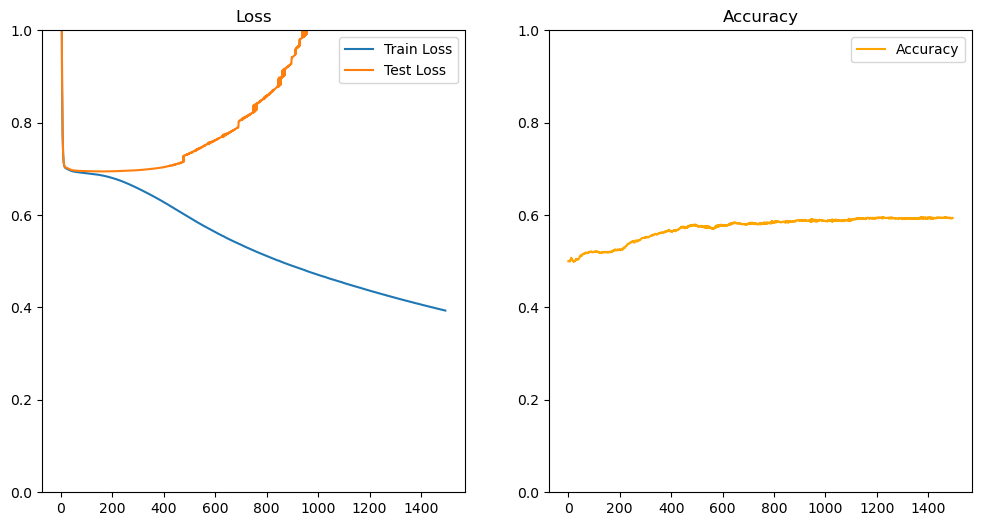

Epoch 1495, Training Loss: 0.39334917068481445, Test Loss: 1.535140037536621, Accuracy: 0.5937


In [13]:
train_loop(text_based, optimizer, 1500, 'word_embs')

In [14]:
from sklearn.metrics import classification_report

def evaluate(model, feature):
    logits = model(G, G.ndata[feature].float())
    pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
    pred = (pred >= 0.5)
    print(classification_report(val_label, pred))

In [15]:
evaluate(text_based, 'word_embs')

              precision    recall  f1-score   support

         0.0       0.62      0.50      0.55      1702
         1.0       0.58      0.69      0.63      1702

    accuracy                           0.59      3404
   macro avg       0.60      0.59      0.59      3404
weighted avg       0.60      0.59      0.59      3404



# Using only graph embeddings

In [16]:
from gensim.models import KeyedVectors

def prepare_graph_embs(G, emb_path='n2c_embs'):
    embs_path = os.path.join(os.pardir, emb_path)
    node_embeddings_dict = KeyedVectors.load_word2vec_format(embs_path)
    G.ndata['node_embs'] = torch.tensor(
        [node_embeddings_dict[node.item()] for node in list(G.nodes())]
    )

In [17]:
prepare_graph_embs(G)

/tmp/ipykernel_2280557/732491567.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718618105212/work/torch/csrc/utils/tensor_new.cpp:274.)
  G.ndata['node_embs'] = torch.tensor(


In [18]:
graph_based = GraphSAGE(64, 128)
optimizer = torch.optim.Adam(chain(graph_based.parameters(), G.ndata['node_embs']), lr=0.001)

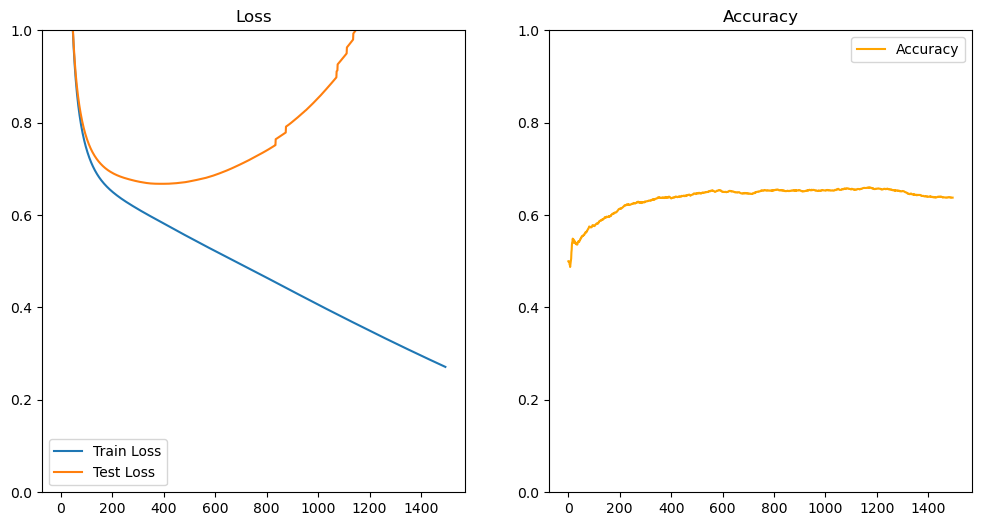

Epoch 1495, Training Loss: 0.27140378952026367, Test Loss: 1.5487619638442993, Accuracy: 0.6378


In [19]:
train_loop(graph_based, optimizer, 1500, 'node_embs')

In [20]:
evaluate(graph_based, 'node_embs')

              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59      1702
         1.0       0.61      0.74      0.67      1702

    accuracy                           0.64      3404
   macro avg       0.64      0.64      0.63      3404
weighted avg       0.64      0.64      0.63      3404



# Combine text and graph embeddings

In [21]:
def cat_emb(G, word_emb_path='embeddings_50.npy', node_emb_path='n2c_embs'):
    node_emb_path = os.path.join(os.pardir, node_emb_path)
    node_embeddings_dict = KeyedVectors.load_word2vec_format(node_emb_path)
    node_embs = torch.tensor(
        [node_embeddings_dict[node.item()] for node in list(G.nodes())]
    )

    word_embs = np.load(os.path.join(os.pardir, word_emb_path))
    node_properties = pd.read_csv(os.path.join(os.pardir, 'data', 'processed.csv'))
    paper_id2emb_id = {elem: i for i, elem in enumerate(node_properties['Paper_ID'])}
    word_embs = torch.from_numpy(np.array([word_embs[paper_id2emb_id[id_]] for id_ in dgl_ids]))

    G.ndata['cat_embs'] = torch.cat([node_embs, word_embs], dim=1)

In [22]:
cat_emb(G)

In [23]:
cat_based = GraphSAGE(114, 128)
optimizer = torch.optim.Adam(chain(cat_based.parameters(), G.ndata['cat_embs']), lr=0.001)

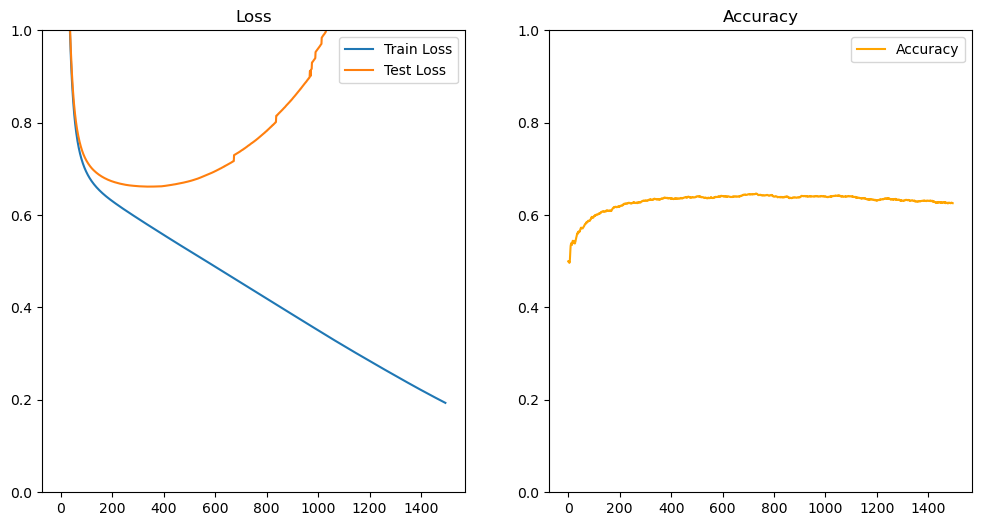

Epoch 1495, Training Loss: 0.19353249669075012, Test Loss: 2.1696178913116455, Accuracy: 0.6257


In [24]:
train_loop(cat_based, optimizer, 1500, 'cat_embs')

In [26]:
evaluate(cat_based, 'cat_embs')

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57      1702
         1.0       0.60      0.75      0.67      1702

    accuracy                           0.63      3404
   macro avg       0.63      0.63      0.62      3404
weighted avg       0.63      0.63      0.62      3404



# Each network overfits. Let's add dropout
## For text-based:

In [27]:
prepare_text_embs(G)
dropout_text_based = GraphSAGE(50, 128, dropout=True)
optimizer = torch.optim.Adam(chain(dropout_text_based.parameters(), G.ndata['word_embs']), lr=0.001)

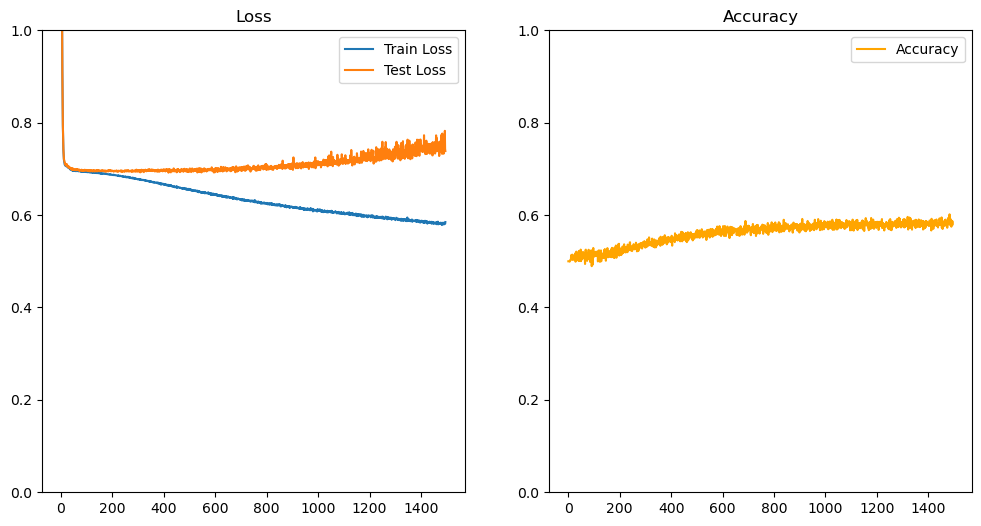

Epoch 1495, Training Loss: 0.5848610997200012, Test Loss: 0.7384910583496094, Accuracy: 0.5799


In [28]:
train_loop(dropout_text_based, optimizer, 1500, 'word_embs')

In [29]:
evaluate(dropout_text_based, 'word_embs')

              precision    recall  f1-score   support

         0.0       0.62      0.41      0.50      1702
         1.0       0.56      0.75      0.64      1702

    accuracy                           0.58      3404
   macro avg       0.59      0.58      0.57      3404
weighted avg       0.59      0.58      0.57      3404



## For graph-based

In [30]:
prepare_graph_embs(G)
dropout_graph_based = GraphSAGE(64, 128, dropout=True)
optimizer = torch.optim.Adam(chain(dropout_graph_based.parameters(), G.ndata['node_embs']), lr=0.001)

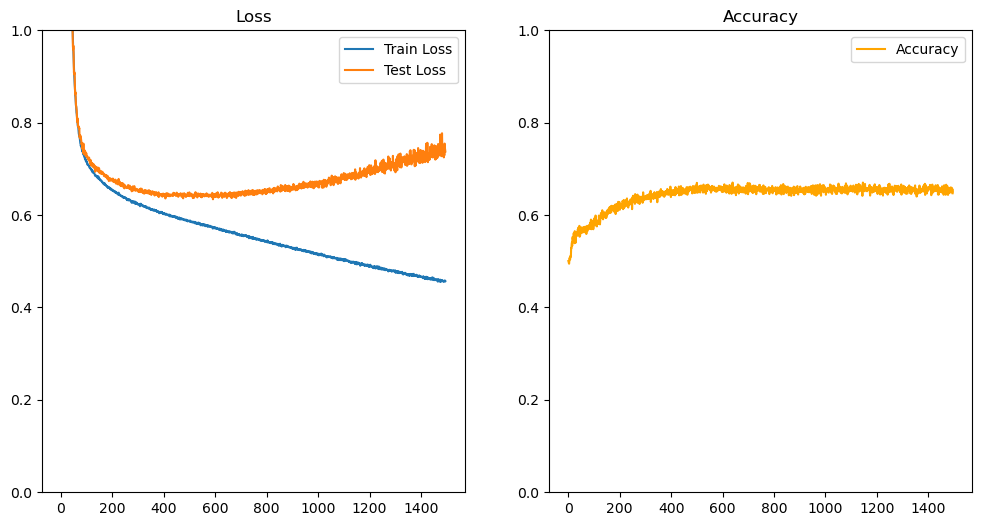

Epoch 1495, Training Loss: 0.4568314850330353, Test Loss: 0.737576425075531, Accuracy: 0.6472


In [31]:
train_loop(dropout_graph_based, optimizer, 1500, 'node_embs')

In [32]:
evaluate(dropout_graph_based, 'node_embs')

              precision    recall  f1-score   support

         0.0       0.72      0.50      0.59      1702
         1.0       0.62      0.80      0.70      1702

    accuracy                           0.65      3404
   macro avg       0.67      0.65      0.64      3404
weighted avg       0.67      0.65      0.64      3404



## For combined:

In [33]:
cat_emb(G)
dropout_cat_based = GraphSAGE(114, 128, dropout=True)
optimizer = torch.optim.Adam(chain(dropout_cat_based.parameters(), G.ndata['cat_embs']), lr=0.001)

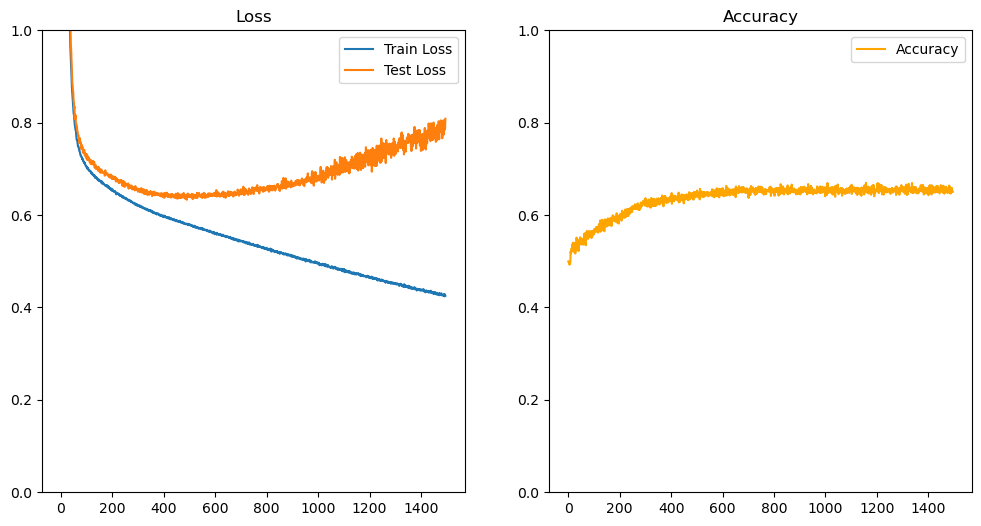

Epoch 1495, Training Loss: 0.4254539906978607, Test Loss: 0.8085566163063049, Accuracy: 0.6501


In [34]:
train_loop(dropout_cat_based, optimizer, 1500, 'cat_embs')

In [35]:
evaluate(dropout_cat_based, 'cat_embs')

              precision    recall  f1-score   support

         0.0       0.72      0.50      0.59      1702
         1.0       0.62      0.81      0.70      1702

    accuracy                           0.66      3404
   macro avg       0.67      0.66      0.65      3404
weighted avg       0.67      0.66      0.65      3404



# :(